In [1]:
"""
Módulo unificado para entrenamiento de Redes Neuronales Bayesianas (BNN) con MFVI,
ajustado para mejorar RMSE manteniendo la cuantificación de incertidumbre.

Cambios clave respecto a la versión anterior:
1) Escalado correcto de la KL por minibatch con annealing de beta.
2) Scheduler de tasa de aprendizaje tipo MultiStepLR.
3) Clipping de gradiente para estabilidad.
4) Inicialización del ruido más baja.
5) Priors algo más amplios e init_std mayor.
6) Aumento de épocas y ajuste de learning rate en el ejemplo.
7) Corrección en prepare_individual_data para no usar variables indefinidas.
8) Semillas para reproducibilidad.

Nota: No se usa el ID de la estación como variable predictora.
"""

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
import seaborn as sns
import joblib
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from typing import Dict, List, Tuple, Optional, Union
import warnings
import statsmodels.api as sm
from scipy.stats import zscore
import math
import argparse

warnings.filterwarnings('ignore')
torch.classes.__path__ = []  # estabilidad para entornos sin extensiones

# Constante para estabilidad numérica
EPS = 1e-6

# ==================== COMPONENTES BNN (MFVI) ====================

class MFVILinear(nn.Module):
    """Capa lineal Bayesiana usando Inferencia Variacional de Campo Medio (MFVI)."""

    def __init__(self, dim_in, dim_out, prior_weight_std=1.5, prior_bias_std=1.5, init_std=0.10, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out

        self.weight_mean = nn.Parameter(torch.empty((dim_out, dim_in), **factory_kwargs))
        self.bias_mean = nn.Parameter(torch.empty(dim_out, **factory_kwargs))
        self._weight_std_param = nn.Parameter(torch.empty((dim_out, dim_in), **factory_kwargs))
        self._bias_std_param = nn.Parameter(torch.empty(dim_out, **factory_kwargs))
        
        self.reset_parameters(init_std)

        prior_mean = 0.0
        self.register_buffer('prior_weight_mean', torch.full_like(self.weight_mean, prior_mean))
        self.register_buffer('prior_weight_std', torch.full_like(self._weight_std_param, prior_weight_std))
        self.register_buffer('prior_bias_mean', torch.full_like(self.bias_mean, prior_mean))
        self.register_buffer('prior_bias_std', torch.full_like(self._bias_std_param, prior_bias_std))

    def reset_parameters(self, init_std=0.10):
        nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
        bound = self.dim_in ** -0.5 if self.dim_in > 0 else 0
        nn.init.uniform_(self.bias_mean, -bound, bound)
        _init_std_param = np.log(init_std)
        self._weight_std_param.data = torch.full_like(self.weight_mean, _init_std_param)
        self._bias_std_param.data = torch.full_like(self.bias_mean, _init_std_param)

    @property
    def weight_std(self):
        return torch.clamp(torch.exp(self._weight_std_param), min=EPS)

    @property
    def bias_std(self):
        return torch.clamp(torch.exp(self._bias_std_param), min=EPS)

    def kl_divergence(self):
        q_weight = dist.Normal(self.weight_mean, self.weight_std)
        p_weight = dist.Normal(self.prior_weight_mean, self.prior_weight_std)
        kl = dist.kl_divergence(q_weight, p_weight).sum()
        
        q_bias = dist.Normal(self.bias_mean, self.bias_std)
        p_bias = dist.Normal(self.prior_bias_mean, self.prior_bias_std)
        kl += dist.kl_divergence(q_bias, p_bias).sum()
        return kl

    def forward(self, input):
        weight = self._normal_sample(self.weight_mean, self.weight_std)
        bias = self._normal_sample(self.bias_mean, self.bias_std)
        return F.linear(input, weight, bias)

    def _normal_sample(self, mean, std):
        epsilon = torch.randn_like(std)
        return mean + std * epsilon


def make_mfvi_bnn(layer_sizes, activation='GELU', **layer_kwargs):
    nonlinearity = getattr(nn, activation)() if isinstance(activation, str) else activation
    net = nn.Sequential()
    for i, (dim_in, dim_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        net.add_module(f'MFVILinear{i}', MFVILinear(dim_in, dim_out, **layer_kwargs))
        if i < len(layer_sizes) - 2:
            net.add_module(f'Nonlinarity{i}', nonlinearity)
    return net


def kl_divergence_model(bnn):
    kl = 0.0
    for module in bnn.modules():
        if hasattr(module, 'kl_divergence'):
            kl += module.kl_divergence()
    return kl


def gauss_loglik(y, y_pred, log_noise_var):
    # y: (N,1) o broadcast a (K,N,1); y_pred: (K,N,1) o (N,1)
    l2_dist = (y - y_pred).pow(2).sum(-1)
    return -0.5 * (log_noise_var + math.log(2 * math.pi) + l2_dist * torch.exp(-log_noise_var))


def test_nll(y, y_pred, log_noise_var):
    nll_samples = -gauss_loglik(y, y_pred, log_noise_var)  # (K, N)
    nll = -torch.logsumexp(-nll_samples, dim=0) + math.log(nll_samples.shape[0])
    return nll.mean()

# ==================== DATASET PYTORCH ====================

class BayesianDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.target = torch.tensor(target.values, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

# ==================== ENTRENADOR UNIFICADO ====================

class BNNUnifiedTrainer:
    """
    Clase unificada para entrenamiento de BNNs que maneja tanto modelos individuales 
    como globales con una interfaz consistente.
    """
    
    def __init__(self):
        self.df_master = None
        self.model = None
        self.scaler_dict = {}
        self.scaler_target = None
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        # Semillas
        torch.manual_seed(42)
        np.random.seed(42)
        if 'cuda' in self.device:
            torch.cuda.manual_seed_all(42)
        print(f"Using device: {self.device}")

    def load_data(self) -> pd.DataFrame:
        """Cargar datos desde el archivo parquet."""
        try:
            df = pd.read_parquet('../data/super_processed/7_4_no2_with_traffic_and_1meteo_and_1trafic_id.parquet')
            df['fecha'] = pd.to_datetime(df['fecha'])
            return df
        except Exception as e:
            print(f"Error al cargar los datos: {str(e)}")
            raise e
    
    def get_available_sensors(self) -> List[str]:
        """Obtener lista de sensores disponibles en los datos."""
        if self.df_master is None:
            self.df_master = self.load_data()
        return sorted(self.df_master['id_no2'].unique().tolist())

    def remove_outliers(self, df: pd.DataFrame, method: str, columns: List[str] = None) -> pd.DataFrame:
        """Remover outliers usando el método especificado."""
        if method == 'none': 
            return df
        
        if columns is None:
            columns = ['no2_value']
            
        df_filtered = df.copy()
        for col in columns:
            if col not in df_filtered.columns: 
                continue
            if method == 'iqr':
                Q1, Q3 = df_filtered[col].quantile(0.25), df_filtered[col].quantile(0.75)
                IQR = Q3 - Q1
                if IQR > 0:
                    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
                    df_filtered = df_filtered[(df_filtered[col] >= lower) & (df_filtered[col] <= upper)]
            elif method == 'zscore':
                df_filtered = df_filtered[np.abs(zscore(df_filtered[col], nan_policy='omit')) < 3]
        return df_filtered

    def split_data(self, df: pd.DataFrame, split_date: pd.Timestamp) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Dividir datos por fecha."""
        train = df[df['fecha'] < split_date].copy()
        test = df[df['fecha'] >= split_date].copy()
        return train, test

    def scale_features(self, X_train: pd.DataFrame, X_test: pd.DataFrame, features: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
        """Escalar características usando StandardScaler."""
        scaler_dict = {}
        X_train_s, X_test_s = X_train.copy(), X_test.copy()
        for feature in features:
            if feature in X_train.columns and pd.api.types.is_numeric_dtype(X_train[feature]):
                scaler = StandardScaler()
                X_train_s[feature] = scaler.fit_transform(X_train[[feature]]).flatten()
                X_test_s[feature] = scaler.transform(X_test[[feature]]).flatten()
                scaler_dict[feature] = scaler
        return X_train_s, X_test_s, scaler_dict

    def scale_target(self, y_train: pd.Series) -> Tuple[pd.Series, StandardScaler]:
        """Escalar variable objetivo."""
        scaler = StandardScaler()
        y_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        return pd.Series(y_scaled, index=y_train.index, name=y_train.name), scaler
    
    
    def temporal_train_val_split(self, df: pd.DataFrame, frac_val: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """División temporal: la cola más reciente se usa como validación."""
        if len(df) < 5:
            return df.copy(), df.iloc[0:0].copy()
        df_sorted = df.sort_values('fecha')
        n_val = max(1, int(len(df_sorted) * frac_val))
        train_df = df_sorted.iloc[:-n_val].copy()
        val_df = df_sorted.iloc[-n_val:].copy()
        return train_df, val_df


    def prepare_individual_data(self, config: Dict, selected_features: List[str]) -> Dict:
        """Preparar datos para entrenamiento individual."""
        print(f"\n📊 Preparando datos para sensor individual: {config['sensor_id']}")
        
        # Filtrar por sensor
        df_sensor = self.df_master[self.df_master['id_no2'] == config['sensor_id']].copy()
        if df_sensor.empty:
            print(f"❌ Error: No se encontraron datos para el sensor {config['sensor_id']}")
            return {}

        print(f"📊 Datos originales del sensor: {len(df_sensor)}")
        
        # División temporal
        train_df, test_df = self.split_data(df_sensor, pd.to_datetime(config['split_date']))
        
        # Remover outliers solo en entrenamiento si aplica
        outliers_removed = 0
        if config['outlier_method'] != 'none':
            len_before = len(train_df)
            train_df = self.remove_outliers(train_df, config['outlier_method'], ['no2_value'])
            outliers_removed = len_before - len(train_df)
            print(f"❌ Outliers eliminados: {outliers_removed}")
        
        print(f"📅 Datos entrenamiento finales: {len(train_df)}")
        print(f"📅 Datos test finales: {len(test_df)}")
        
        return {
            'train_df': train_df,
            'test_df': test_df,
            'outliers_removed': outliers_removed,
            'mode': 'individual',
            'sensor_id': config['sensor_id']
        }

    def prepare_global_data(self, config: Dict, selected_features: List[str]) -> Dict:
        """Preparar datos para entrenamiento global (múltiples sensores)."""
        print(f"\n🌍 Preparando datos para modelo global multi-sensor")
        print(f"   Sensores entrenamiento: {config['sensors_train']}")
        print(f"   Sensores test: {config['sensors_test']}")
        
        df_train = self.df_master[self.df_master['id_no2'].isin(config['sensors_train'])].copy()
        df_test = self.df_master[self.df_master['id_no2'].isin(config['sensors_test'])].copy()
        
        print(f"📊 Datos entrenamiento originales: {len(df_train)}")
        print(f"📊 Datos test originales: {len(df_test)}")
        
        # División temporal adicional
        df_train = df_train[df_train['fecha'] < pd.to_datetime(config['split_date'])].copy()
        df_test = df_test[df_test['fecha'] >= pd.to_datetime(config['split_date'])].copy()
        
        # Validar que todas las features existen
        missing_features_train = [f for f in selected_features if f not in df_train.columns]
        missing_features_test = [f for f in selected_features if f not in df_test.columns]
        
        if missing_features_train or missing_features_test:
            print(f"❌ Features faltantes en train: {missing_features_train}")
            print(f"❌ Features faltantes en test: {missing_features_test}")
            return {}
        
        # Remover outliers solo en entrenamiento si aplica
        outliers_removed = 0
        if config['outlier_method'] != 'none':
            len_before = len(df_train)
            df_train = self.remove_outliers(df_train, config['outlier_method'], ['no2_value'])
            outliers_removed = len_before - len(df_train)
            print(f"❌ Outliers eliminados: {outliers_removed}")
        
        print(f"📅 Datos entrenamiento finales: {len(df_train)}")
        print(f"📅 Datos test finales: {len(df_test)}")
        
        return {
            'train_df': df_train,
            'test_df': df_test,
            'outliers_removed': outliers_removed,
            'mode': 'global',
            'sensors_train': config['sensors_train'],
            'sensors_test': config['sensors_test']
        }

    
    def predict(self, model, X_test, K, log_noise_var):
        """Realizar predicciones con el modelo BNN."""
        model.eval()
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            y_preds = torch.stack([model(X_test_tensor) for _ in range(K)], dim=0)  # (K, N, 1)
        
        pred_mean = y_preds.mean(0)  # (N,1)
        epistemic_uncertainty = y_preds.var(0).sqrt()  # (N,1)
        aleatoric_uncertainty = torch.exp(0.5 * log_noise_var).expand_as(pred_mean)  # (N,1)
        total_uncertainty = (epistemic_uncertainty**2 + aleatoric_uncertainty**2).sqrt()
        
        return {
            'y_preds_all': y_preds,
            'mean': pred_mean,
            'epistemic_std': epistemic_uncertainty,
            'aleatoric_std': aleatoric_uncertainty,
            'total_std': total_uncertainty
        }
        
    def train_bnn_model(self, X_train, y_train, train_config, X_val=None, y_val=None):
        """Entrenar BNN con validación opcional y logging de pérdidas."""
        dataset = BayesianDataset(X_train, y_train)
        auto_bs = min(train_config['batch_size'], max(64, len(dataset) // 4))
        train_loader = DataLoader(dataset, batch_size=auto_bs, shuffle=True)

        # Dataset de validación si procede
        val_loader = None
        if X_val is not None and y_val is not None and len(X_val) > 0:
            val_dataset = BayesianDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=min(2048, len(val_dataset)), shuffle=False)

        layer_sizes = [X_train.shape[1]] + train_config['hidden_dims'] + [1]
        model = make_mfvi_bnn(
            layer_sizes,
            activation=train_config['activation'],
            prior_weight_std=1.0,
            prior_bias_std=1.0,
            init_std=0.05,
            device=self.device
        ).to(self.device)

        log_noise_var = nn.Parameter(torch.ones(1, device=self.device) * -3.0)
        params = list(model.parameters()) + [log_noise_var]
        optimizer = torch.optim.Adam(params, lr=train_config['learning_rate'])

        T = train_config['n_epochs']
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(0.6*T), int(0.85*T)], gamma=0.5
        )

        warmup = max(1, int(0.6 * T))
        logs = []
        N_data = len(dataset)

        print("🚀 Iniciando entrenamiento BNN...")
        for epoch in range(T):
            model.train()
            beta_t = train_config['beta'] * min(1.0, (epoch + 1) / warmup)
            sum_nll, sum_kl, seen = 0.0, 0.0, 0

            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
                optimizer.zero_grad()
                y_pred = model(x_batch)
                nll = -gauss_loglik(y_batch, y_pred, log_noise_var).mean()
                kl = kl_divergence_model(model)
                loss = nll + beta_t * kl * (len(x_batch) / N_data)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                sum_nll += nll.item() * len(x_batch)
                sum_kl += kl.item()
                seen += len(x_batch)

            scheduler.step()
            nll_train = sum_nll / max(1, seen)
            kl_train = sum_kl / max(1, seen)

            # Validación: solo likelihood para medir generalización
            nll_val = None
            if val_loader is not None:
                model.eval()
                with torch.no_grad():
                    total, count = 0.0, 0
                    for x_val_b, y_val_b in val_loader:
                        x_val_b = x_val_b.to(self.device)
                        y_val_b = y_val_b.to(self.device)
                        y_val_pred = model(x_val_b)
                        nll_b = -gauss_loglik(y_val_b, y_val_pred, log_noise_var).mean()
                        total += nll_b.item() * len(x_val_b)
                        count += len(x_val_b)
                    nll_val = total / max(1, count)

            lr_now = optimizer.param_groups[0]['lr']
            logs.append({'epoch': epoch+1, 'nll_train': nll_train, 'nll_val': nll_val, 'kl': kl_train, 'lr': lr_now})

            if (epoch + 1) % 20 == 0:
                msg = f"   Epoch {epoch+1}/{T} | beta_t={beta_t:.3f} | NLL_train: {nll_train:.3f}"
                if nll_val is not None:
                    msg += f" | NLL_val: {nll_val:.3f}"
                msg += f" | KL: {kl_train:.3f}"
                print(msg)

        print("✅ Entrenamiento completado.")
        return model, log_noise_var, logs


    def evaluate_model(self, predictions, y_test, y_test_scaled, scaler_target, log_noise_var, sensor_id: str = None):
        """Evaluar el modelo y calcular métricas."""
        # Desescalar predicciones
        pred_mean_scaled = predictions['mean'].detach().cpu().numpy()
        pred_mean = scaler_target.inverse_transform(pred_mean_scaled).flatten()
        
        total_std_scaled = predictions['total_std'].detach().cpu().numpy().flatten()
        unscaled_std = total_std_scaled * scaler_target.scale_[0]
        
        epistemic_std = predictions['epistemic_std'].detach().cpu().numpy().flatten()
        epistemic_unscaled_std = epistemic_std * scaler_target.scale_[0]

        # Guardar predicciones
        df_preds = pd.DataFrame({
            'prediction': pred_mean,
            'epistemic_uncertainty': epistemic_unscaled_std
        })
        sensor_suffix = f"_{sensor_id}" if sensor_id else "_global"
        filename = f'../predictions/bnn_predictions_with_epistemic_uncertainty{sensor_suffix}.csv'
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        df_preds.to_csv(filename, index=False)
        print(f"💾 Predicciones guardadas en: {filename}")

        # Métricas
        rmse = np.sqrt(mean_squared_error(y_test, pred_mean))
        r2 = r2_score(y_test, pred_mean)
        mae = mean_absolute_error(y_test, pred_mean)
        
        # Test NLL
        y_test_tensor = torch.tensor(y_test_scaled.values, dtype=torch.float32).reshape(-1, 1).to(self.device)
        nll = test_nll(y_test_tensor, predictions['y_preds_all'], log_noise_var).item()
        
        return {
            'rmse': rmse, 'r2': r2, 'mae': mae, 'test_nll': nll,
            'y_pred': pred_mean, 'y_pred_std': unscaled_std,
            'predictions_df': df_preds
        }

    def evaluate_global_by_sensor(self, data_prep: Dict, model, log_noise_var, scaler_dict, 
                                  scaler_target, selected_features, K_predict: int) -> Dict:
        """Evaluar modelo global por sensor individual."""
        results_by_sensor = {}
        test_df = data_prep['test_df']
        
        print(f"\n🔍 Evaluando modelo global por sensor individual...")
        
        for sensor_id in data_prep['sensors_test']:
            print(f"   📊 Evaluando sensor: {sensor_id}")
            
            sensor_test_df = test_df[test_df['id_no2'] == sensor_id].copy()
            if len(sensor_test_df) == 0:
                print(f"      ⚠️ No hay datos de test para sensor {sensor_id}")
                continue
            
            X_test_sensor = sensor_test_df[selected_features].copy()
            y_test_sensor = sensor_test_df['no2_value'].copy()
            
            # Escalado con scalers del entrenamiento global
            X_test_sensor_scaled = X_test_sensor.copy()
            for feature in selected_features:
                if feature in scaler_dict:
                    X_test_sensor_scaled[feature] = scaler_dict[feature].transform(X_test_sensor[[feature]]).flatten()
            
            y_test_sensor_scaled = pd.Series(
                scaler_target.transform(y_test_sensor.values.reshape(-1, 1)).flatten(),
                index=y_test_sensor.index,
                name=y_test_sensor.name
            )
            
            predictions = self.predict(model, X_test_sensor_scaled, K_predict, log_noise_var)
            metrics = self.evaluate_model(predictions, y_test_sensor, y_test_sensor_scaled, 
                                          scaler_target, log_noise_var, sensor_id)
            
            results_by_sensor[sensor_id] = {
                'metrics': metrics,
                'test_df': sensor_test_df,
                'n_samples': len(sensor_test_df)
            }
            
            print(f"      RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.3f}, MAE: {metrics['mae']:.2f}")
        
        return results_by_sensor
    
    def save_model(self, path: str, model, log_noise_var, scaler_dict, scaler_target, 
                   feature_names: List[str], model_config: Dict = None):
        """Guardar modelo entrenado."""
        os.makedirs(os.path.dirname(path), exist_ok=True)
        model_state = {
            'model_state_dict': model.state_dict(),
            'log_noise_var': log_noise_var,  # tensor con grad
            'scaler_dict': scaler_dict,
            'scaler_target': scaler_target,
            'feature_names': feature_names,
            'model_config': model_config or {}
        }
        joblib.dump(model_state, path)
        print(f"💾 Modelo guardado en: {path}")

    def load_model(self, path: str, layer_sizes: List[int], activation: str = 'GELU'):
        """Cargar modelo guardado."""
        if not os.path.exists(path):
            print(f"❌ Modelo no encontrado en: {path}")
            return None
        
        model_state = joblib.load(path)
        model = make_mfvi_bnn(layer_sizes, activation=activation, device=self.device).to(self.device)
        model.load_state_dict(model_state['model_state_dict'])
        log_noise_var = model_state['log_noise_var'].to(self.device)
        
        return (model, log_noise_var, model_state['scaler_dict'], 
                model_state['scaler_target'], model_state['feature_names'])

# ==================== VISUALIZACIÓN Y REPORTE ====================

def print_model_metrics(metrics: Dict, title: str = "Métricas de Evaluación"):
    """Mostrar métricas del modelo."""
    print(f"\n📊 {title}")
    print(f"  RMSE: {metrics['rmse']:.2f} µg/m³")
    print(f"  R²: {metrics['r2']:.3f}")
    print(f"  MAE: {metrics['mae']:.2f} µg/m³")
    print(f"  Test NLL: {metrics['test_nll']:.3f}")

def print_global_summary(results_by_sensor: Dict):
    """Mostrar resumen de resultados globales por sensor."""
    print(f"\n🌍 Resumen Modelo Global - Resultados por Sensor")
    print("="*60)
    
    all_rmse = [results_by_sensor[sensor]['metrics']['rmse'] for sensor in results_by_sensor]
    all_r2 = [results_by_sensor[sensor]['metrics']['r2'] for sensor in results_by_sensor]
    all_mae = [results_by_sensor[sensor]['metrics']['mae'] for sensor in results_by_sensor]
    
    print(f"Métricas Promedio:")
    print(f"  RMSE Promedio: {np.mean(all_rmse):.2f} µg/m³ (±{np.std(all_rmse):.2f})")
    print(f"  R² Promedio: {np.mean(all_r2):.3f} (±{np.std(all_r2):.3f})")
    print(f"  MAE Promedio: {np.mean(all_mae):.2f} µg/m³ (±{np.std(all_mae):.2f})")
    
    print(f"\nDetalle por Sensor:")
    for sensor_id in sorted(results_by_sensor.keys()):
        result = results_by_sensor[sensor_id]
        metrics = result['metrics']
        print(f"  {sensor_id}: RMSE={metrics['rmse']:.2f}, R²={metrics['r2']:.3f}, MAE={metrics['mae']:.2f}, n={result['n_samples']}")

def save_training_loss_plot(logs: List[Dict], filename: str):
    """Guardar gráfico de curvas de entrenamiento (NLL train, NLL val, KL) y un CSV con los logs."""
    print(f"📉 Guardando curvas de entrenamiento en {filename}")
    log_df = pd.DataFrame(logs)
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # Guardar CSV de logs junto al PNG
    base, ext = os.path.splitext(filename)
    csv_path = base + "_logs.csv"
    log_df.to_csv(csv_path, index=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    ax1.plot(log_df['epoch'], log_df['nll_train'], label='Train NLL')
    if 'nll_val' in log_df.columns and log_df['nll_val'].notna().any():
        ax1.plot(log_df['epoch'], log_df['nll_val'], label='Val NLL')
    ax1.set_title("Negative Log-Likelihood")
    ax1.set_xlabel("Época")
    ax1.legend()

    ax2.plot(log_df['epoch'], log_df['kl'], label='KL')
    ax2.set_title("KL Divergence")
    ax2.set_xlabel("Época")

    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.close(fig)
    print(f"💾 Logs guardados en: {csv_path}")


# ==================== FUNCIONES PRINCIPALES ====================

# def main_individual(config: Dict):
#     """Función principal para entrenamiento individual."""
#     print("🧠 Entrenamiento BNN Individual")
#     trainer = BNNUnifiedTrainer()
    
#     # Cargar datos
#     print("\n📂 Cargando datos...")
#     trainer.df_master = trainer.load_data()
#     if trainer.df_master.empty: 
#         return
    
#     print(f"\n⚙️ Configuración Individual:")
#     print(f"  Sensor: {config['sensor_id']}")
#     print(f"  Fecha división: {config['split_date']}")
#     print(f"  Outliers: {config['outlier_method']}")
    
#     # Definir features ANTES de preparar datos
#     sample_data = trainer.df_master[trainer.df_master['id_no2'] == config['sensor_id']].head(100).copy()
#     if sample_data.empty:
#         print(f"❌ Error: No se encontraron datos para el sensor {config['sensor_id']}")
#         return
    
#     all_features = [c for c in sample_data.columns 
#                     if c not in ['fecha', 'id_no2', 'no2_value'] 
#                     and pd.api.types.is_numeric_dtype(sample_data[c])]
    
#     if config['features'] == ['all']:
#         selected_features = all_features
#     else:
#         selected_features = [f for f in config['features'] if f in all_features]
    
#     print(f"\n🔧 Usando {len(selected_features)} características")
#     print("   Características seleccionadas:", selected_features)
    
#     # Preparar datos
#     data_prep = trainer.prepare_individual_data(config, selected_features)
#     if not data_prep:
#         return
    
#     # Matrices
#     X_train = data_prep['train_df'][selected_features]
#     y_train = data_prep['train_df']['no2_value']
#     X_test = data_prep['test_df'][selected_features]
#     y_test = data_prep['test_df']['no2_value']
    
#     # Escalado
#     X_train_scaled, X_test_scaled, scaler_dict = trainer.scale_features(X_train, X_test, selected_features)
#     y_train_scaled, scaler_target = trainer.scale_target(y_train)
#     y_test_scaled = pd.Series(
#         scaler_target.transform(y_test.values.reshape(-1, 1)).flatten(),
#         index=y_test.index, name=y_test.name
#     )
    
#     print(f"📊 Datos: Entrenamiento={len(X_train_scaled)}, Test={len(X_test_scaled)}")
    
#     # Entrenar
#     model, log_noise_var, logs = trainer.train_bnn_model(X_train_scaled, y_train_scaled, config['train_config'])
    
#     # Evaluar
#     print("\n🔍 Evaluando modelo...")
#     predictions = trainer.predict(model, X_test_scaled, config['K_predict'], log_noise_var)
#     metrics = trainer.evaluate_model(predictions, y_test, y_test_scaled, scaler_target, log_noise_var, config['sensor_id'])
    
#     # Resultados
#     print_model_metrics(metrics)
    
#     # Guardar
#     model_path = f"../models/bnn_model_{config['sensor_id']}.pkl"
#     trainer.save_model(model_path, model, log_noise_var, scaler_dict, scaler_target, 
#                        selected_features, config)
    
#     save_training_loss_plot(logs, f"../models/bnn_training_loss_{config['sensor_id']}.png")
    
#     print("\n✅ Proceso individual completado.")
#     return trainer, model, metrics

def main_global(config: Dict):
    """Función principal para entrenamiento global multi-sensor con validación temporal y guardado de curvas."""
    print("🌍 Entrenamiento BNN Global Multi-Sensor")
    trainer = BNNUnifiedTrainer()

    print("\n📂 Cargando datos...")
    trainer.df_master = trainer.load_data()
    if trainer.df_master.empty:
        return

    print(f"\n⚙️ Configuración Global:")
    print(f"  Sensores entrenamiento: {config['sensors_train']}")
    print(f"  Sensores test: {config['sensors_test']}")
    print(f"  Fecha división: {config['split_date']}")
    print(f"  Outliers: {config['outlier_method']}")

    # Definir features antes de preparar datos
    sample_data = trainer.df_master[trainer.df_master['id_no2'].isin(config['sensors_train'])].head(100).copy()

    all_features = [
        c for c in sample_data.columns
        if c not in ['fecha', 'id_no2', 'no2_value']
        and pd.api.types.is_numeric_dtype(sample_data[c])
    ]

    if config['features'] == ['all']:
        selected_features = all_features
    else:
        selected_features = [f for f in config['features'] if f in all_features]

    print(f"\n🔧 Usando {len(selected_features)} características")

    # Preparación de datos global
    data_prep = trainer.prepare_global_data(config, selected_features)
    if not data_prep:
        return

    # Split temporal train–val respetando orden cronológico
    train_full = data_prep['train_df'].copy()
    test_df = data_prep['test_df'].copy()
    val_frac = config.get('val_frac', 0.2)
    train_df, val_df = trainer.temporal_train_val_split(train_full, frac_val=val_frac)

    # Matrices
    X_train = train_df[selected_features]
    y_train = train_df['no2_value']
    X_val = val_df[selected_features]
    y_val = val_df['no2_value']
    X_test = test_df[selected_features]
    y_test = test_df['no2_value']

    # Escalado: ajustar en train y transformar val y test
    X_train_scaled, X_val_scaled, scaler_dict = trainer.scale_features(X_train, X_val, selected_features)
    X_test_scaled = X_test.copy()
    for feature in selected_features:
        if feature in scaler_dict:
            X_test_scaled[feature] = scaler_dict[feature].transform(X_test[[feature]]).flatten()

    y_train_scaled, scaler_target = trainer.scale_target(y_train)
    y_val_scaled = pd.Series(
        scaler_target.transform(y_val.values.reshape(-1, 1)).flatten(),
        index=y_val.index, name=y_val.name
    )
    y_test_scaled = pd.Series(
        scaler_target.transform(y_test.values.reshape(-1, 1)).flatten(),
        index=y_test.index, name=y_test.name
    )

    print(f"📊 Datos: Train={len(X_train_scaled)}, Val={len(X_val_scaled)}, Test={len(X_test_scaled)}")

    # Entrenamiento con validación
    model, log_noise_var, logs = trainer.train_bnn_model(
        X_train_scaled, y_train_scaled, config['train_config'],
        X_val=X_val_scaled, y_val=y_val_scaled
    )

    # Evaluación global
    print("\n🔍 Evaluando modelo global...")
    predictions = trainer.predict(model, X_test_scaled, config['K_predict'], log_noise_var)
    global_metrics = trainer.evaluate_model(
        predictions, y_test, y_test_scaled, scaler_target, log_noise_var, "global"
    )

    # Evaluación por sensor
    sensor_results = trainer.evaluate_global_by_sensor(
        data_prep, model, log_noise_var, scaler_dict, scaler_target,
        selected_features, config['K_predict']
    )

    # Resultados
    print_model_metrics(global_metrics, "Métricas Globales")
    print_global_summary(sensor_results)

    # Guardar modelo y curvas de entrenamiento
    model_path = f"../models/bnn_model_global.pkl"
    trainer.save_model(
        model_path, model, log_noise_var, scaler_dict, scaler_target,
        selected_features, config
    )
    save_training_loss_plot(logs, f"../models/bnn_training_loss_global.png")

    print("\n✅ Proceso global completado.")
    return trainer, model, global_metrics, sensor_results



# ==================== EJEMPLO DE EJECUCIÓN GLOBAL ====================

def ejemplo_global():
    """Ejemplo de entrenamiento global para múltiples sensores sin usar ID como predictor."""
    print("=" * 60)
    print("🌍 EJEMPLO: ENTRENAMIENTO BNN GLOBAL MULTI-SENSOR")
    print("=" * 60)
    
    config = {
        'val_frac':0.2,
        'sensors_train': ['28079004', '28079008', '28079011', '28079016', '28079036', '28079038', '28079039','28079040','28079047', '28079048'],
        'sensors_test': ['28079050', '28079056', '28079035'],
        'split_date': '2024-01-01',
        'outlier_method': 'none',

        'features': [
            # tráfico (nivel + retardos mínimos informativos)
            'intensidad', 'carga',
            'intensidad_lag8', 'carga_lag4', 'carga_lag2'

            # meteorología base y suavizados representativos
            't2m', 't2m_ma6',
            'wind_speed_ma24', 'wind_speed_ewm3',
            'ssrd', 'ssrd_sum24',
            'u10_ewm6',
            'tp_sum24',

            # dirección del viento en base trigonométrica con una sola ventana
            'wind_dir_sin_ma6', 'wind_dir_cos_ma6',

            # tiempo cíclico
            #'hour_sin','hour_cos','dow_sin','dow_cos','month_sin','month_cos'
        ],
        'K_predict': 200,
        'train_config': {
            'learning_rate': 0.003,
            'n_epochs': 100,
            'batch_size': 512,
            'hidden_dims': [64, 32],
            'activation': 'ReLU',
            'beta': 1.0,
        },
        
    }
    
    return main_global(config)


result = ejemplo_global()


🌍 EJEMPLO: ENTRENAMIENTO BNN GLOBAL MULTI-SENSOR
🌍 Entrenamiento BNN Global Multi-Sensor
Using device: cpu

📂 Cargando datos...

⚙️ Configuración Global:
  Sensores entrenamiento: ['28079004', '28079008', '28079011', '28079016', '28079036', '28079038', '28079039', '28079040', '28079047', '28079048']
  Sensores test: ['28079050', '28079056', '28079035']
  Fecha división: 2024-01-01
  Outliers: none

🔧 Usando 13 características

🌍 Preparando datos para modelo global multi-sensor
   Sensores entrenamiento: ['28079004', '28079008', '28079011', '28079016', '28079036', '28079038', '28079039', '28079040', '28079047', '28079048']
   Sensores test: ['28079050', '28079056', '28079035']
📊 Datos entrenamiento originales: 568499
📊 Datos test originales: 167571
📅 Datos entrenamiento finales: 490597
📅 Datos test finales: 22569
📊 Datos: Train=392478, Val=98119, Test=22569
🚀 Iniciando entrenamiento BNN...
   Epoch 20/100 | beta_t=0.333 | NLL_train: 1.201 | NLL_val: 1.193 | KL: 0.957
   Epoch 40/100 | b

In [2]:
df = pd.read_parquet('../data/super_processed/7_4_no2_with_traffic_and_1meteo_and_1trafic_id.parquet')

In [3]:
df = df[df['id_no2'] == '28079050'].copy()

In [4]:
df = df[df['fecha'] >= '2024-01-01']
df = df[['no2_value','fecha']].reset_index().drop(columns='index')

In [5]:
df_predictions = pd.read_csv('../predictions/bnn_predictions_with_epistemic_uncertainty_28079050.csv')

In [6]:
df_predictions_and_actuals = df.merge(df_predictions, left_index=True, right_index=True)

In [7]:
df_predictions_and_actuals

,no2_value,fecha,prediction,epistemic_uncertainty
0,20.0,2024-01-01 00:00:00,38.417180,8.039107
1,28.0,2024-01-01 01:00:00,42.486420,7.915784
2,42.0,2024-01-01 02:00:00,42.621284,8.318727
3,52.0,2024-01-01 03:00:00,46.831560,8.961078
4,53.0,2024-01-01 04:00:00,45.037050,9.392538
...,...,...,...,...
7808,65.0,2024-11-30 20:00:00,44.703470,7.662778
7809,65.0,2024-11-30 21:00:00,49.487648,6.904446
7810,68.0,2024-11-30 22:00:00,51.895540,7.034684
7811,74.0,2024-11-30 23:00:00,52.030293,7.622583


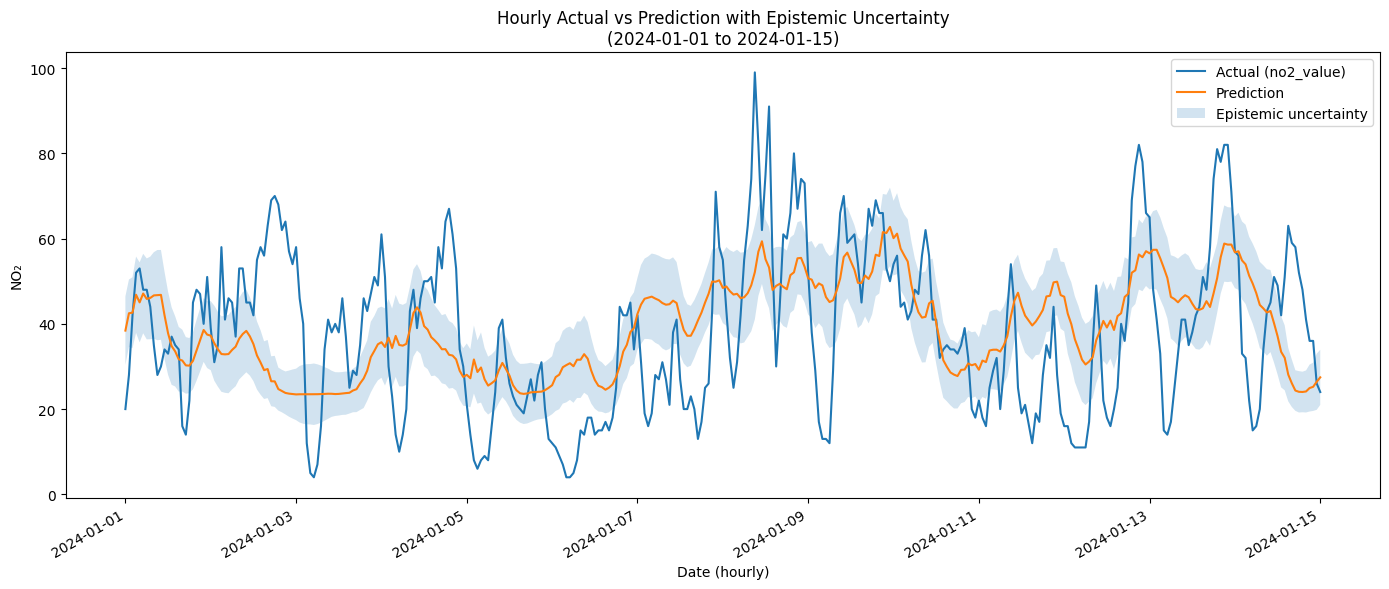

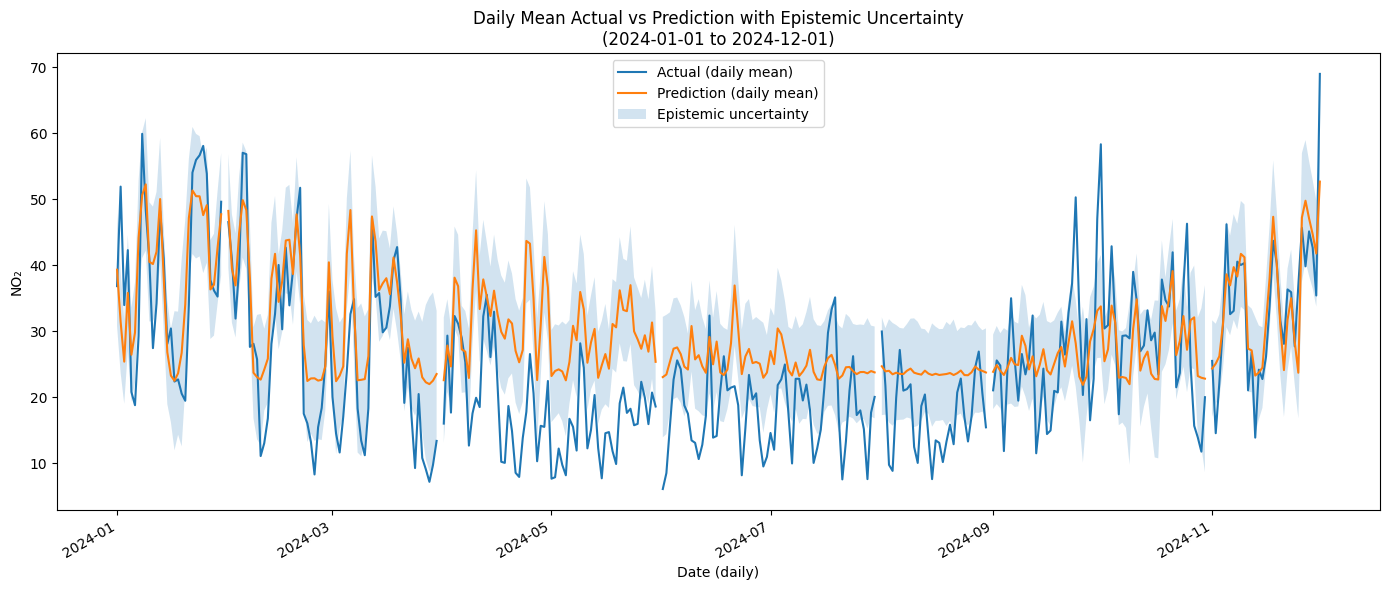

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter

# --- CONFIG ---
# scale for the uncertainty band: 1.0 = ±1×uncertainty; 1.96 ≈ 95% interval
UNCERTAINTY_SCALE = 1.0

# --- Ensure dtypes ---
df = df_predictions_and_actuals.copy()
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
for col in ["no2_value", "prediction", "epistemic_uncertainty"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ------------------------------------------------------------------
# 1) HOURLY: filter 2024-01-01 to 2024-01-15 (inclusive), no transform
# ------------------------------------------------------------------
mask_hourly = (df["fecha"] >= "2024-01-01") & (df["fecha"] <= "2024-01-15")
h = df.loc[mask_hourly, ["fecha", "no2_value", "prediction", "epistemic_uncertainty"]].sort_values("fecha")
h["lower"] = h["prediction"] - UNCERTAINTY_SCALE * h["epistemic_uncertainty"]
h["upper"] = h["prediction"] + UNCERTAINTY_SCALE * h["epistemic_uncertainty"]

fig = plt.figure(figsize=(14, 6))
ax = plt.gca()
x = h["fecha"].to_numpy()
ax.plot(x, h["no2_value"].to_numpy(), label="Actual (no2_value)")
ax.plot(x, h["prediction"].to_numpy(), label="Prediction")
ax.fill_between(x, h["lower"].to_numpy(), h["upper"].to_numpy(), alpha=0.2, label="Epistemic uncertainty")

ax.set_title("Hourly Actual vs Prediction with Epistemic Uncertainty\n(2024-01-01 to 2024-01-15)")
ax.set_xlabel("Date (hourly)")
ax.set_ylabel("NO₂")
ax.legend()
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(AutoDateFormatter(ax.xaxis.get_major_locator()))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 2) DAILY: filter 2024-01-01 to 2024-06-01 (inclusive), daily mean
# ------------------------------------------------------------------
mask_daily = (df["fecha"] >= "2024-01-01") & (df["fecha"] <= "2024-12-01")
d = df.loc[mask_daily, ["fecha", "no2_value", "prediction", "epistemic_uncertainty"]].copy()

# Daily mean for actual, prediction, and (simple) mean of epistemic uncertainty
daily = (
    d.set_index("fecha")
     .resample("D")
     .agg({
         "no2_value": "mean",
         "prediction": "mean",
         "epistemic_uncertainty": "mean"  # simple average; adjust if you prefer another aggregation
     })
     .reset_index()
)
daily["lower"] = daily["prediction"] - UNCERTAINTY_SCALE * daily["epistemic_uncertainty"]
daily["upper"] = daily["prediction"] + UNCERTAINTY_SCALE * daily["epistemic_uncertainty"]

fig = plt.figure(figsize=(14, 6))
ax = plt.gca()
x = daily["fecha"].to_numpy()
ax.plot(x, daily["no2_value"].to_numpy(), label="Actual (daily mean)")
ax.plot(x, daily["prediction"].to_numpy(), label="Prediction (daily mean)")
ax.fill_between(x, daily["lower"].to_numpy(), daily["upper"].to_numpy(), alpha=0.2, label="Epistemic uncertainty")

ax.set_title("Daily Mean Actual vs Prediction with Epistemic Uncertainty\n(2024-01-01 to 2024-12-01)")
ax.set_xlabel("Date (daily)")
ax.set_ylabel("NO₂")
ax.legend()
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(AutoDateFormatter(ax.xaxis.get_major_locator()))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
